<a href="https://colab.research.google.com/github/LuFernandez/PASA/blob/master/nuestroperodemaxi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Filtrado óptimo

Procesamiento Adaptativo de Señales Aleatorias

© 2019 Parra, Rocío

© 2019 Fernandez, Lucero Guadalupe

In [0]:
from scipy.io import wavfile
import numpy as np
import scipy as scipy
import matplotlib.pyplot as plt


##1. Cargamos datos

###Muestras

In [3]:
#cargo datos
fs_music, music_aux = wavfile.read('lorde.wav')
fs_voice, voice_aux = wavfile.read('sofunny.wav')
fs_square, square = wavfile.read('cuadrada.wav')
fs_lin, lin = wavfile.read('sweeplin.wav')
fs_log, log = wavfile.read('sweeplog.wav')
fs_noise, noise = wavfile.read('ruido.wav')
voice = voice_aux[:,0]
music = music_aux[:,0]

#vectores de tiempo
t_music = np.linspace(0,len(music)/fs_music, len(music))
t_voice = np.linspace(0,len(voice)/fs_voice, len(voice))
t_square = np.linspace(0,len(square)/fs_square, len(square))
t_lin = np.linspace(0,len(lin)/fs_lin, len(lin))
t_log = np.linspace(0,len(log)/fs_log, len(log))
t_noise = np.linspace(0,len(noise)/fs_noise, len(noise))

/usr/local/lib/python3.6/dist-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


###Grabaciones

In [0]:
#cargo datos
fs_music_r, music_r_aux = wavfile.read('grab-lorde.wav')
fs_voice_r, voice_r_aux = wavfile.read('grab-sofunny.wav')
fs_square_r, square_r_aux = wavfile.read('grab-cuadrada.wav')
fs_lin_r, lin_r_aux = wavfile.read('grab-sweeplin.wav')
fs_log_r, log_r_aux = wavfile.read('grab-sweeplog.wav')
fs_noise_r, noise_r_aux = wavfile.read('grab-ruido.wav')
music_r = music_r_aux[:,0]
voice_r = voice_r_aux[:,0]
square_r = square_r_aux[:,0]
lin_r = lin_r_aux[:,0]
log_r = log_r_aux[:,0]
noise_r = noise_r_aux[:,0]

#vectores de tiempo
t_music_r_aux = np.linspace(0,len(music_r)/fs_music_r, len(music_r))
t_voice_r_aux = np.linspace(0,len(voice_r)/fs_voice_r, len(voice_r))
t_square_r_aux = np.linspace(0,len(square_r)/fs_square_r, len(square_r))
t_lin_r_aux = np.linspace(0,len(lin_r)/fs_lin_r, len(lin_r))
t_log_r_aux = np.linspace(0,len(log_r)/fs_log_r, len(log_r))
t_noise_r_aux = np.linspace(0,len(noise_r)/fs_noise_r, len(noise_r))

###Ploteo las grabaciones y las samples para ver que estén bien superpuestas

In [0]:
#shifts para que las señales empiecen igual
music_shift = 0.555
voice_shift = 1.174   #ok
square_shift = .3
lin_shift = 0.45
log_shift = 0.3
noise_shift = 0.7


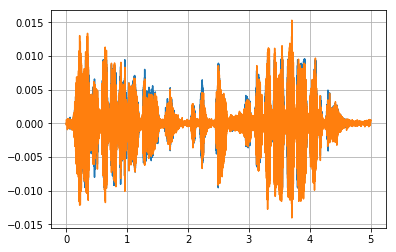

In [6]:
#musica
# plt.figure()
# plt.plot(t_music, music[:, 0])
# plt.plot(t_music_r[int(music_shift*fs_music_r):]-music_shift, music_r[int(music_shift*fs_music_r):])
#falta cortar los cuatro vectores acaaaaacasdasdasdasdasd                    a


#voz
plt.figure()
voice_r = voice_r[int(voice_shift*fs_voice_r):]
t_voice_r = t_voice_r_aux[int(voice_shift*fs_voice_r):]-voice_shift
voice =  voice/np.linalg.norm(voice)   #normalizo
voice_r =  voice_r/np.linalg.norm(voice_r)  #normalizo
# voice =  voice/max(voice)   #normalizo
# voice_r =  voice_r/max(voice_r)  #normalizo
plt.plot(t_voice, voice)
plt.plot(t_voice_r, voice_r)

#cuadrada
# plt.figure()
# plt.plot(t_square, square)
# plt.plot(t_square_r[int(square_shift*fs_square_r):]-square_shift, square_r[int(square_shift*fs_square_r):])


#sweep lineal
# plt.figure()
# plt.plot(t_lin, lin)
# plt.plot(t_lin_r[int(lin_shift*fs_lin_r):]-lin_shift, lin_r[int(lin_shift*fs_lin_r):])


#sweep logaritmico
# plt.figure()
# plt.plot(t_log, log)
# plt.plot(t_log_r[int(log_shift*fs_log_r):]-log_shift, log_r[int(log_shift*fs_log_r):])


#ruido
# plt.figure()
# plt.plot(t_noise, noise)
# plt.plot(t_noise_r[int(noise_shift*fs_noise_r):]-noise_shift, noise_r[int(noise_shift*fs_noise_r):])


plt.grid()
plt.show()

In [0]:
# import pandas
# df = pandas.DataFrame(np.vstack(voice_r[:len(voice)//20]))
# R = df.cov()

In [0]:
import scipy.sparse.linalg as sp

In [13]:
N = min(len(voice), len(voice_r))
voice = voice[0:N-1]
voice_r = voice_r[0:N-1]
L = 100


def adjustSignals(fs,u,d,deltaT):
    ##Agrego ceros si alguna señal tiene diferente tamaño
    diff = len(u) - len(d)
    if(diff > 0):
        d = np.concatenate((d,[0 for _ in range(diff)]))
    elif(diff < 0):
        u = np.concatenate((u,[0 for _ in range(-diff)]))
    
    ##Agrego un segundo de ceros al principio y al final
    uZ = np.array([0 for i in range(0,1*fs)])
    uZ = np.concatenate((uZ,u))
    uZ = np.concatenate((uZ,[0 for i in range(0,1*fs)]))

    dZ = np.array([0 for i in range(0,1*fs)])
    dZ = np.concatenate((dZ,d))
    dZ = np.concatenate((dZ,[0 for i in range(0,1*fs)]))
    return uZ,dZ
uZ, dZ =adjustSignals(fs_voice,voice,voice_r,1)

def estimateParams(u,d):
    u_f = np.fft.fft(u)
    d_f = np.fft.fft(d)
    
    ##Estimo la autocorrelación
    #r = np.correlate(u,u,mode='same')
    print("Calculando R...")
    r = np.fft.ifft(u_f * u_f.conj()).real
    r = r[:len(u)//2]/len(u)

    ##Estimo la correlación cruzada
    #p = np.correlate(u,d,mode='same')
    print("Calculando P...")
    p = np.fft.ifft(u_f * d_f.conj()).real
    p = p[len(u)//2:]/len(u)
    p = np.flip(p)

    ##Energía de la señal deseada
    sigma2d = np.var(d)
    return r,p,sigma2d


# lR, R, _, _ =plt.xcorr(voice, voice, maxlags=L)
# R = R[L:]/N
# lp, p, _, _ =plt.xcorr(voice[:len(voice_r)], voice_r[:len(voice_r)], maxlags=L)
# p = p[L:]/N
# p=np.flip(p)

r, p, sigmad = estimateParams(voice, voice_r)
r = r[0:L-1]
p = p[0:L-1]
R = scipy.linalg.toeplitz(r)
Rinv = np.linalg.inv(R)

#sigmad = np.sum(np.power(voice_r, 2))/len(voice_r)

Calculando R...
Calculando P...


In [0]:
def calc_optimum_filter(sigma2, Rinv, p):
    '''
    Calcula el filtro Wiener óptimo
    
    sigma2: energía de la señal de entrada
    R: matriz de autocorrelación
    p: vector de correlación cruzada
    '''
    
    wo = np.dot(Rinv, p)
    Jmin = sigma2 - p.dot(wo)
    return (wo, Jmin)

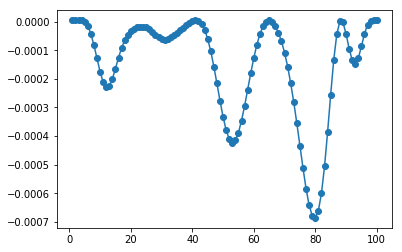

In [15]:
Mmax = 100

Jmin = np.zeros(Mmax)
for M in range(1, Mmax + 1):
    wo, Jmin[M - 1] = calc_optimum_filter(sigmad, Rinv[0:M, 0:M], p[0:M])

# plt.figure(figsize=(8, 12))
plt.figure()
plt.plot(range(1, Mmax + 1), Jmin, marker='o')
# plt.xlabel('$M$', fontsize=14)
# plt.ylim(0.0)
# plt.ylabel('$J_{min}(M)$', fontsize=14)
plt.show()
